# Notebook for Authorship Attribution using multichanels

In [1]:
#python basic libs
import os;
from os.path import join as pathjoin;
import zipfile;

import re;
import random;
import json;
from collections import defaultdict, Counter;
from pprint import pprint
from time import time

In [2]:
%matplotlib inline
#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;

In [3]:
#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import feature_selection;

#preprocessing and transformation
from sklearn import preprocessing;
from sklearn import decomposition;

from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm
from sklearn import ensemble
from sklearn import tree
from sklearn import metrics

#
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score;

In [4]:
#import spacy;
import gensim
import logging
from gensim.models import KeyedVectors
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.CRITICAL)

In [5]:
from IPython.display import Markdown, display, HTML

In [6]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
np.set_printoptions(precision=4)
pd.options.display.float_format = '{:,.4f}'.format
sns.set(color_codes=True);

In [8]:
import platform;
import sklearn;
import scipy;

Markdown(
    "|%-15s|%-65s|\n"%("PACK","VERSION") +
    "|%-15s|%-65s|\n"%('-'*15,'-'*65) +
    ('\n'.join(
    "|%-15s|%-45s| " % (pack, version.strip())
    for pack, version in
    zip(['SO','NumPy','SciPy','Scikit-Learn','Seaborn','Gensim'],
        [platform.platform(), np.__version__, scipy.__version__,
         sklearn.__version__, sns.__version__,  gensim.__version__])

)))

|PACK           |VERSION                                                          |
|---------------|-----------------------------------------------------------------|
|SO             |Windows-10-10.0.17763-SP0                    | 
|NumPy          |1.16.2                                       | 
|SciPy          |1.2.1                                        | 
|Scikit-Learn   |0.20.3                                       | 
|Seaborn        |0.9.0                                        | 
|Gensim         |3.7.2                                        | 

In [9]:
baseDir = '../data/';
corpusTraining    = 'pan18-cross-domain-authorship-attribution-training-dataset-2017-12-02';
corpusEvaluation = 'pan18-cross-domain-authorship-attribution-test-dataset2-2018-04-20';
corpusEach1 = 'AvaliacaoPT';

currentCorpus = corpusEvaluation;

inputDir= pathjoin(baseDir,currentCorpus);
outputDir= pathjoin(baseDir,'out');
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

In [10]:
import pan
import sklearnExtensions
from sklearnExtensions import DenseTransformer

In [11]:
problems = pan.readCollectionsOfProblems2019(inputDir);

In [12]:
pd.DataFrame(problems)

,candidates,encoding,language,problem-name,unknown
0,[[hairdryer currently turned on high.\n ...,UTF-8,en,problem00001,[[still wearing a cool smile. He turned it on ...
1,"[[hey, perhaps he'd like to test that authorit...",UTF-8,en,problem00002,[[It had seemed like a good idea at the time.\...
2,[[MORE BLISSED OUT AT THE VERY FACT THAT THEY ...,UTF-8,en,problem00003,"[[or even worse, accept them) – and you’d foll..."
3,[[to feel Link inside of him anyways. Ever sin...,UTF-8,en,problem00004,[[Every night they brought them. New sacrific...
4,[[Du coin de l'œil il pouvait voir le sourire ...,UTF-8,fr,problem00005,"[[mêler de leurs affaires.\n\nMais voilà, elle..."
5,"[[ai pas vu s'agrandir et s'affirmer, jusqu'à ...",UTF-8,fr,problem00006,[[est quoi ? » Il désigna de sa canne les bou...
6,"[[qui allait tout revomir ensuite, Varus serra...",UTF-8,fr,problem00007,"[[était une sorte de monstre. « Sirius, ne re..."
7,[[même expérience que toi par rapport aux vamp...,UTF-8,fr,problem00008,"[[une entrée brusque et terrifiante, tel un va..."
8,[[aveva usato anche uno squallidissimo doppio ...,UTF-8,it,problem00009,[[ \n\n \n\n \n\nAlbus è così intelligente che...
9,[[\n\n\n\n\n\n\n\n'Sarai mio.'\n\n\n\n\n\n\n\n...,UTF-8,it,problem00010,"[[giorno della gita ad Hogsmeade, sarebbe venu..."


In [13]:
pd.DataFrame(problems[0]['unknown'],columns=['text','label','file']).head(10)

,text,label,file
0,still wearing a cool smile. He turned it on th...,candidate00020,unknown00001.txt
1,"hear you if they were close enough, you will y...",candidate00003,unknown00002.txt
2,"all, Albus, I need to prepare classes fo-“\n\n...",candidate00005,unknown00003.txt
3,"be gone, and the softer, less offending light ...",candidate00001,unknown00004.txt
4,"full of rubble, buildings toppled and streetla...",candidate00005,unknown00005.txt
5,"bed. He was sure of it, that this was his puni...",candidate00018,unknown00006.txt
6,"terrible, wonderful things to him. ""Then I'll ...",candidate00018,unknown00007.txt
7,"more depressing, however, is the proclamation ...",candidate00005,unknown00008.txt
8,finally dozing off when the sound of the Floo ...,candidate00012,unknown00009.txt
9,"wand.""\n\nHuh. That was unexpected, but Draco ...",candidate00018,unknown00010.txt


In [14]:
pd.DataFrame(problems).groupby(['language']).count().reset_index()

,language,candidates,encoding,problem-name,unknown
0,en,4,4,4,4
1,fr,4,4,4,4
2,it,4,4,4,4
3,pl,4,4,4,4
4,sp,4,4,4,4


In [15]:
def tag(p):
    df = pd.concat([
            pd.DataFrame(p['candidates']),
            pd.DataFrame(p['unknown'])]
    );
    df.columns=['text','candidate','fandom'];
    df['text_char_length'] = df['text'].apply(lambda x:len(x))
    df['text_word_length'] = df['text'].apply(lambda x:len(re.findall(r'\b\w+\b',x)))

    #df.drop(columns=['fandom'],inplace=True)
    df['set'] = ['train']*len(p['candidates']) + ['val']*len(p['unknown'])
    df['problem-name'] = p['problem-name'];
    df['language'] = p['language'];
    return df;
df = pd.concat([tag(p) for p in problems])

p1 = pd.pivot_table(df,index=['problem-name'], columns='set', values=['text_char_length','text_word_length'],aggfunc='mean')

def a(x):
    c= x[['text','candidate']].groupby('candidate').count().reset_index();
    
    return pd.Series({
     'docs_per_author': c['text'].mean()
    })
    
p2 = df.groupby(['problem-name','set']).apply(a).reset_index().pivot(index='problem-name',columns='set')

corpus_stats = pd.merge(p1,p2,on='problem-name')

In [16]:
def readBaseline():
    baselines = ['svm_evaluation'];
    baselineResults  = [json.load(open('./outputEvaluation/'+f+'/out.json')) for f in baselines];
    
    #converting the overall into a row
    baselineResults2 = []
    for p,b in zip(baselineResults,baselines):
        t = p['problems'];
        t.append({'problem-name':'overall', 'macro-f1':p['overall_score']})
        for tt in t:
            tt['method'] = b;
        baselineResults2 +=t;
    
    baselineResults2 = pd.DataFrame(baselineResults2);
    return baselineResults2;

baselineResults = readBaseline()


In [17]:
p3 = baselineResults[['problem-name','method','macro-f1']].pivot(index='problem-name',columns='method')

In [18]:
pd.merge(corpus_stats,p3,on='problem-name')\
    .style.background_gradient(cmap=sns.light_palette("gray", as_cmap=True),axis=0)

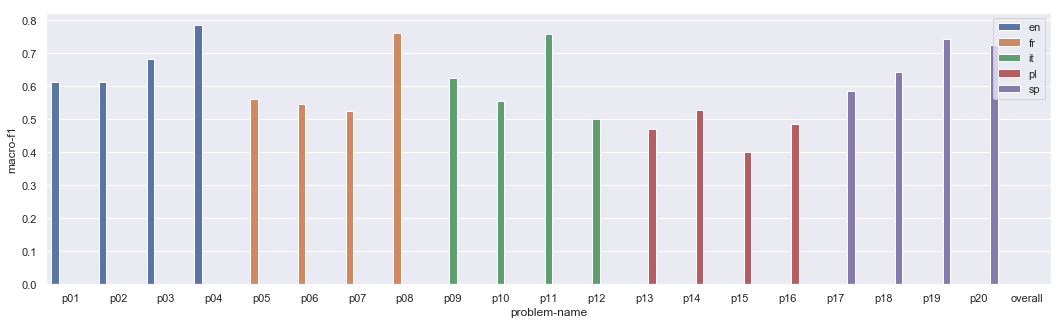

In [19]:
def a():
    df = pd.merge(
        pd.DataFrame(baselineResults),
        pd.DataFrame(problems)[['problem-name','language']],
        on='problem-name',
        how='left'
    );
    df['problem-name'] = df['problem-name'].apply(lambda x: x.replace('problem000','p'))
    plt.figure(figsize=(18,5))
    sns.barplot(data=df, x='problem-name',y='macro-f1', hue='language');
    plt.legend(loc=1);
    #plt.title("Macro-F1 score")
a();

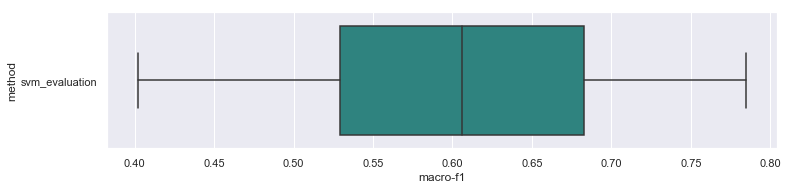

In [20]:
def a():
    df = pd.DataFrame(baselineResults);
    df['problem-name'] = df['problem-name'].apply(lambda x: x.replace('problem000',''))
    plt.figure(figsize=(12,2.5))
    sns.boxplot(data=pd.DataFrame(baselineResults),x='macro-f1', y='method',whis="range", palette="viridis");
a();

In [21]:
def upsample_text(texts, labels, min_doc_sample = 10):
    texts = texts.copy();
    labels = labels.copy();
    counter = Counter(labels);
    doc_per_label = max(max(counter.values()),min_doc_sample);
    
    new_texts  = [];
    new_labels = [];
    
    for label, cnt in counter.items():
        temp_texts = [t for t,l in zip(texts,labels) if l == label];
        
        while cnt < doc_per_label:
            texts_sizes = np.array([len(t) for t in temp_texts]);
            #in descending order;
            temp_texts = np.array(temp_texts)[np.argsort(-texts_sizes)].tolist();
            
            text = temp_texts.pop(0);
            l = int(0.25*len(text));
            temp_texts.append(text[:(len(text)-l)])
            temp_texts.append(text[l:]);
            
            cnt = len(temp_texts)
            
        
        new_texts  += temp_texts;
        new_labels += [label] * cnt;
        
    
    indexes = np.arange(len(new_texts));
    np.random.shuffle(indexes);
        
    return np.array(new_texts)[indexes].tolist(), np.array(new_labels)[indexes].tolist()
    
#train_docs, train_labels = upsample_text(train_docs, train_labels);

In [22]:
def eval_measures(test_labels, predictions):
    gt = {i:label for i,label in enumerate(test_labels) }
    pred = {i:label for i,label in enumerate(predictions) }
    
    ## keep pan original eval code
    actual_authors = list(gt.values())
    encoder = preprocessing.LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')


    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        labels=list(set(gold_author_ints))
        # Exclude the <UNK> class
        f1 = metrics.f1_score(gold_author_ints, silver_author_ints,labels,average='macro')
        precision = metrics.precision_score(gold_author_ints, silver_author_ints,labels,average='macro')
        recall = metrics.recall_score(gold_author_ints, silver_author_ints,labels,average='macro')
        accuracy = metrics.accuracy_score(gold_author_ints,silver_author_ints)

    return f1,precision,recall,accuracy

# Main Logic

In [23]:
def runModel(problem, pipeline, parameters, probCut=0.055,upsample=0, n_jobs=-1,verbose=False):
    print ("\nProblem: %s,  language: %s, " %(problem['problem-name'],problem['language']), end=' ')
    
    train_docs, train_labels, _ = zip(*problem['candidates'])
    test_docs, test_labels, _   = zip(*problem['unknown'])
    
    if upsample> 0:
        train_docs, train_labels = upsample_text(list(train_docs), list(train_labels),min_doc_sample=upsample);
    
    grid_search = GridSearchCV(pipeline,
                               parameters,cv=3,
                               iid=False, n_jobs=n_jobs, verbose=verbose, scoring='f1_macro')
    
    t0 = time()
    grid_search.fit(train_docs, train_labels);
    grid_search.best_estimator_.fit(train_docs, train_labels)
    
    print("Gridsearh %0.3fs" % (time() - t0))

    test_pred      =grid_search.predict(test_docs);
    test_pred_proba=grid_search.predict_proba(test_docs);
    dist = test_pred_proba.std(axis=1);
    
    f1,precision,recall,accuracy = eval_measures(test_labels,test_pred)
    report = metrics.classification_report(test_labels,test_pred, output_dict=True);
    print("Best score: %0.3f - Test score: %0.3f - in %0.3fs" % (grid_search.best_score_, f1, time() - t0))
    best_parameters = grid_search.best_estimator_.get_params()
    print("'"+problem['language']+"':{")
    for param_name in sorted(parameters.keys()):
        print("\t'%s': %r," % (param_name, best_parameters[param_name]))
    print("},")
    
    return {
                'problem-name'  : problem['problem-name'],
                'f1'       : round(f1,4),
                'accuracy' : round(accuracy,4),
                'report'   : report,
                'best_cut' : round(distmax,4)
                
        }, grid_search.cv_results_,best_parameters;

In [24]:
def runGrid(funct):
    result = [];
    cv_result = [];
    best_parameters = [];
    for problem in problems:
        r, c, b = funct(problem);
        result.append(r);
        cv_result.append(c);
        b['problem-name'] = problem['problem-name'];
        best_parameters.append(b);
    return {'result':result,'cv':cv_result,'best_params':best_parameters};

In [25]:
allResults = {};

In [29]:
def runCharModel(problem):
    pipeline = Pipeline([
        ('vect',TfidfVectorizer(analyzer='char',
                ngram_range=(2,5),
                min_df=0.01,
                lowercase=False,
                smooth_idf=True,
                sublinear_tf=True,
                norm='l1',
                dtype=np.float32,
                )),
        ('scaler', preprocessing.MaxAbsScaler()),
        #('selection',feature_selection.SelectPercentile(percentile=90)),
        #('dense',DenseTransformer()),
        ('pca'  ,decomposition.TruncatedSVD(100)),
        ('clf', linear_model.LogisticRegression(random_state=0,C=1,multi_class='multinomial', solver='newton-cg')),
    ])
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((2,4),(2,5)),
        'vect__sublinear_tf':(True,False),
    }
    return runModel(problem,pipeline, parameters,upsample=0,n_jobs=-1,verbose=True)

In [30]:
allResults['char'] =runGrid(runCharModel);


Problem: problem00001,  language: en,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.2min remaining:   25.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.2min finished


Gridsearh 134.943s
Best score: 0.843 - Test score: 0.392 - in 136.346s
'en':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': True,
},

Problem: problem00002,  language: en,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.3min remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.3min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 81.795s
Best score: 0.844 - Test score: 0.514 - in 83.110s
'en':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': True,
},

Problem: problem00003,  language: en,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   45.8s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   46.0s finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 49.046s
Best score: 0.895 - Test score: 0.645 - in 49.854s
'en':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': True,
},

Problem: problem00004,  language: en,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   21.1s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   21.2s finished


Gridsearh 23.578s
Best score: 0.873 - Test score: 0.830 - in 24.132s
'en':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': True,
},

Problem: problem00005,  language: fr,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.7min remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.7min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\skl

Gridsearh 107.075s
Best score: 0.821 - Test score: 0.368 - in 108.714s
'fr':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': True,
},

Problem: problem00006,  language: fr,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.2min remaining:   14.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.2min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 78.415s
Best score: 0.866 - Test score: 0.360 - in 80.560s
'fr':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': False,
},

Problem: problem00007,  language: fr,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   39.5s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   39.9s finished


Gridsearh 45.914s
Best score: 0.837 - Test score: 0.519 - in 47.144s
'fr':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': False,
},

Problem: problem00008,  language: fr,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   24.6s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   24.6s finished


Gridsearh 27.070s
Best score: 0.868 - Test score: 0.707 - in 27.636s
'fr':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': False,
},

Problem: problem00009,  language: it,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.9min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.9min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 117.856s
Best score: 0.838 - Test score: 0.270 - in 119.714s
'it':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': False,
},

Problem: problem00010,  language: it,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.5min remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 93.882s
Best score: 0.841 - Test score: 0.506 - in 95.213s
'it':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': False,
},

Problem: problem00011,  language: it,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   52.4s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   52.5s finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 55.248s
Best score: 0.899 - Test score: 0.761 - in 55.912s
'it':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': False,
},

Problem: problem00012,  language: it,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   21.9s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   22.0s finished


Gridsearh 23.309s
Best score: 0.929 - Test score: 0.375 - in 24.088s
'it':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': False,
},

Problem: problem00013,  language: pl,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.1min remaining:   25.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.1min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 140.642s
Best score: 0.875 - Test score: 0.175 - in 144.637s
'pl':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': False,
},

Problem: problem00014,  language: pl,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.5min remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 100.253s
Best score: 0.879 - Test score: 0.178 - in 103.737s
'pl':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': False,
},

Problem: problem00015,  language: pl,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   46.2s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   46.7s finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 50.392s
Best score: 0.942 - Test score: 0.475 - in 51.431s
'pl':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': True,
},

Problem: problem00016,  language: pl,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   27.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   27.8s finished


Gridsearh 31.250s
Best score: 0.865 - Test score: 0.384 - in 32.366s
'pl':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': True,
},

Problem: problem00017,  language: sp,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  2.5min remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.5min finished


Gridsearh 158.466s
Best score: 0.861 - Test score: 0.266 - in 161.978s
'sp':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': True,
},

Problem: problem00018,  language: sp,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.8min remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.8min finished


Gridsearh 114.399s
Best score: 0.845 - Test score: 0.395 - in 117.149s
'sp':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': True,
},

Problem: problem00019,  language: sp,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   58.1s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   58.2s finished
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\jose.custodio\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


Gridsearh 64.437s
Best score: 0.989 - Test score: 0.753 - in 66.292s
'sp':{
	'vect__ngram_range': (2, 5),
	'vect__sublinear_tf': True,
},

Problem: problem00020,  language: sp,  Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   27.1s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   27.2s finished


Gridsearh 28.545s
Best score: 1.000 - Test score: 0.704 - in 29.108s
'sp':{
	'vect__ngram_range': (2, 4),
	'vect__sublinear_tf': True,
},


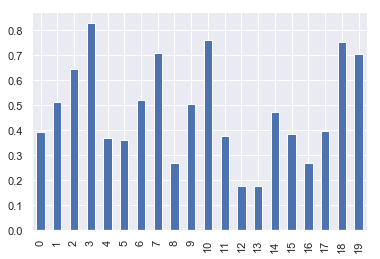

In [38]:
pd.DataFrame(allResults['char']['result'])['f1'].plot(kind='bar')